In [ ]:
from utils import load_and_prepare_nb15
from neural_network import NeuralNetwork, FocalLoss
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dataset_path = './Dataset/NF-UNSW-NB15-v3.csv'

numerical_cols = [
    "NUM_PKTS_128_TO_256_BYTES",
    "RETRANSMITTED_OUT_PKTS",
    "SRC_TO_DST_IAT_STDDEV",
    "SRC_TO_DST_SECOND_BYTES",
    "IN_PKTS",
    "LONGEST_FLOW_PKT",
    "NUM_PKTS_256_TO_512_BYTES",
    "DST_TO_SRC_IAT_AVG",
    "OUT_BYTES",
    "NUM_PKTS_UP_TO_128_BYTES",
    "DURATION_OUT",
    "NUM_PKTS_512_TO_1024_BYTES",
    "SRC_TO_DST_IAT_AVG",
    "DURATION_IN",
    "SHORTEST_FLOW_PKT",
    "RETRANSMITTED_IN_PKTS",
    "FLOW_DURATION_MILLISECONDS",
    "IN_BYTES",
    "MIN_IP_PKT_LEN",
    "TCP_WIN_MAX_OUT",
    "SRC_TO_DST_IAT_MIN",
    "RETRANSMITTED_OUT_BYTES",
    "DST_TO_SRC_IAT_MAX",
    "DST_TO_SRC_SECOND_BYTES",
    "DNS_TTL_ANSWER",
    "NUM_PKTS_1024_TO_1514_BYTES",
    "SRC_TO_DST_AVG_THROUGHPUT",
    "DST_TO_SRC_IAT_STDDEV",
    "OUT_PKTS",
    "SRC_TO_DST_IAT_MAX",
    "TCP_WIN_MAX_IN",
    "MAX_IP_PKT_LEN",
    "DST_TO_SRC_AVG_THROUGHPUT",
    "DST_TO_SRC_IAT_MIN",
    "RETRANSMITTED_IN_BYTES"

    ]

categorical_cols = [
    "PROTOCOL",
    "L7_PROTO",
    "TCP_FLAGS",
    "CLIENT_TCP_FLAGS",
    "SERVER_TCP_FLAGS",
    "ICMP_TYPE",
    "ICMP_IPV4_TYPE",
    "DNS_QUERY_TYPE",
    "FTP_COMMAND_RET_CODE"
    ]

target_col = 'Attack'

In [ ]:
train_dataloader, valid_dataloader, test_dataloader, cat_cardinalities, cw, target_names = load_and_prepare_nb15(
    file_path=dataset_path,
    target_col=target_col,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    batch_size=4096
)

In [3]:
model = NeuralNetwork(
    hidden_layers_sizes=[256, 256, 256], 
    cat_cardinalities=cat_cardinalities,
    embedding_dims=[min(50, (card + 1) // 2) for card in cat_cardinalities],
    num_numerical_features=len(numerical_cols),
    num_target_classes=6,
)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.85, patience=5)

In [ ]:
model.fit(
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    device=device,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    epochs=100,
    weights = cw
)

--- Epoch: 0  |  Loss: 0.4088  |  F1 Score: 0.7387  |  Accuracy: 0.8529 ---
--- Epoch: 1  |  Loss: 0.3123  |  F1 Score: 0.8200  |  Accuracy: 0.9307 ---
--- Epoch: 2  |  Loss: 0.2388  |  F1 Score: 0.8704  |  Accuracy: 0.9433 ---
--- Epoch: 3  |  Loss: 0.1973  |  F1 Score: 0.8487  |  Accuracy: 0.9464 ---
--- Epoch: 4  |  Loss: 0.1703  |  F1 Score: 0.8520  |  Accuracy: 0.9450 ---
--- Epoch: 5  |  Loss: 0.1663  |  F1 Score: 0.8620  |  Accuracy: 0.9473 ---
--- Epoch: 6  |  Loss: 0.1195  |  F1 Score: 0.9068  |  Accuracy: 0.9651 ---
--- Epoch: 7  |  Loss: 0.1255  |  F1 Score: 0.8758  |  Accuracy: 0.9576 ---
--- Epoch: 8  |  Loss: 0.1043  |  F1 Score: 0.9234  |  Accuracy: 0.9696 ---
--- Epoch: 9  |  Loss: 0.1418  |  F1 Score: 0.9223  |  Accuracy: 0.9643 ---
--- Epoch: 10  |  Loss: 0.2000  |  F1 Score: 0.9075  |  Accuracy: 0.9559 ---
--- Epoch: 11  |  Loss: 0.1065  |  F1 Score: 0.9355  |  Accuracy: 0.9728 ---
--- Epoch: 12  |  Loss: 0.1200  |  F1 Score: 0.9050  |  Accuracy: 0.9635 ---
--- Epoch


=== Classification Report ===
              precision    recall  f1-score   support

        ddos     0.9900    0.9949    0.9925     50615
   injection     0.9717    0.9871    0.9794     50967
      normal     0.9677    0.9906    0.9790      9197
    password     0.9980    0.9972    0.9976    189474
    scanning     0.7829    0.9942    0.8760      4686
         xss     0.9980    0.9867    0.9924    211140

    accuracy                         0.9916    516079
   macro avg     0.9514    0.9918    0.9695    516079
weighted avg     0.9922    0.9916    0.9917    516079



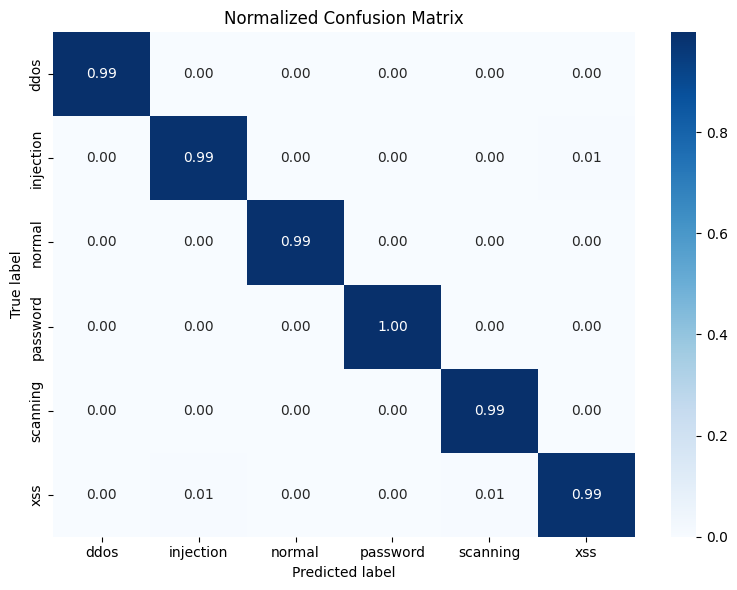

In [ ]:
best_model = NeuralNetwork.load('best_model.pt', device=device)

y_pred = best_model.predict(test_dataloader, device)
y_true = torch.cat([y for _, _, y in test_dataloader]).numpy()


print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred.numpy(), target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred.numpy(), normalize='true')  
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()